# KNN
* 이재민이 실행하는 KNN 코드입니다.

In [ ]:
# ============================================================
# 02_train_classical_ml.ipynb
#
# Train classical ML models (KNN, SVM, Decision Tree,
# Random Forest, XGBoost) on Colored MNIST.
#
# - Uses preprocessed features from 01_preprocessing_colored_mnist.ipynb
# - Supports 3 tasks:
#     1) Digit classification (0-9)
#     2) Foreground color classification (7 classes, ROYGBIV)
#     3) Background color classification (7 classes, ROYGBIV)
# ============================================================

import os  # path handling
import numpy as np  # numerical operations
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # nicer plots

from sklearn.metrics import (  # evaluation metrics
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV  # hyperparameter tuning

from sklearn.neighbors import KNeighborsClassifier  # KNN model
from sklearn.svm import SVC  # SVM model
from sklearn.tree import DecisionTreeClassifier  # Decision Tree model
from sklearn.ensemble import RandomForestClassifier  # Random Forest model



# Matplotlib style (English only)
plt.rcParams["font.family"] = "DejaVu Sans"  # default font
plt.rcParams["axes.unicode_minus"] = False  # minus sign
sns.set(style="whitegrid")  # seaborn style

RANDOM_STATE = 42  # global random seed for reproducibility

print("[OK] Libraries imported.")


# ------------------------------------------------------------
# Resolve BASE_DIR and processed npz path
# ------------------------------------------------------------
cwd = os.getcwd()  # current working directory

# If current folder is 'notebooks', use its parent as repo root
if os.path.basename(cwd) == "notebooks":  # check folder name
    BASE_DIR = os.path.dirname(cwd)  # go one level up
else:
    BASE_DIR = cwd  # otherwise use current directory as root

PROCESSED_PATH = os.path.join(
    BASE_DIR, "data", "processed", "colored_mnist", "colored_mnist.npz"
)  # path to preprocessed npz

print(f"[INFO] BASE_DIR       : {BASE_DIR}")
print(f"[INFO] PROCESSED_PATH : {PROCESSED_PATH}")

if not os.path.exists(PROCESSED_PATH):  # check if file exists
    raise FileNotFoundError(
        f"[ERROR] Processed file not found at {PROCESSED_PATH}.\n"
        f"Please run 01_preprocessing_colored_mnist.ipynb first."
    )

data = np.load(PROCESSED_PATH)  # load npz file into memory
print("[OK] Loaded npz keys:", list(data.keys()))


# ------------------------------------------------------------
# Extract features (scaled + raw)
#   - X_*     : standardized features (mean=0, std=1) for classical ML
#   - X_*_raw : flattened RGB in [0,1] (for PCA or other future use)
# ------------------------------------------------------------
X_train = data["X_train"].astype(np.float32)  # scaled train features
X_val   = data["X_val"].astype(np.float32)    # scaled val features
X_test  = data["X_test"].astype(np.float32)   # scaled test features

X_train_raw = data["X_train_raw"].astype(np.float32)  # raw train features (0-1)
X_val_raw   = data["X_val_raw"].astype(np.float32)    # raw val features
X_test_raw  = data["X_test_raw"].astype(np.float32)   # raw test features

print("[INFO] Feature shapes (scaled):")
print("  X_train:", X_train.shape)
print("  X_val  :", X_val.shape)
print("  X_test :", X_test.shape)

print("[INFO] Raw features are loaded as well, reserved for future use (e.g., PCA).")


# ------------------------------------------------------------
# Define color names (same order as in 01_preprocessing)
# ------------------------------------------------------------
COLOR_NAMES = ["red", "orange", "yellow", "green", "blue", "indigo", "violet"]  # 7 colors


# ------------------------------------------------------------
# Select task: "digit", "fg", or "bg"
# ------------------------------------------------------------
TASK = "digit"  # change to "fg" or "bg" depending on experiment

if TASK == "digit":
    y_train = data["y_digit_train"]  # digit labels for train
    y_val   = data["y_digit_val"]    # digit labels for val
    y_test  = data["y_digit_test"]   # digit labels for test
    class_names = [str(i) for i in range(10)]  # class names "0"~"9"
    print("[TASK] Digit classification (0-9).")
elif TASK == "fg":
    y_train = data["y_fg_train"]  # foreground color labels for train
    y_val   = data["y_fg_val"]    # foreground color labels for val
    y_test  = data["y_fg_test"]   # foreground color labels for test
    class_names = COLOR_NAMES     # class names are color names
    print("[TASK] Foreground color classification.")
elif TASK == "bg":
    y_train = data["y_bg_train"]  # background color labels for train
    y_val   = data["y_bg_val"]    # background color labels for val
    y_test  = data["y_bg_test"]   # background color labels for test
    class_names = COLOR_NAMES     # class names are color names
    print("[TASK] Background color classification.")
else:
    raise ValueError("TASK must be one of: 'digit', 'fg', 'bg'.")

print("[INFO] Label shapes:")
print("  y_train:", y_train.shape)
print("  y_val  :", y_val.shape)
print("  y_test :", y_test.shape)
print("  num_classes:", len(class_names))

[OK] Libraries imported.
[INFO] BASE_DIR       : c:\src\colored-mnist-classification
[INFO] PROCESSED_PATH : c:\src\colored-mnist-classification\data\processed\colored_mnist\colored_mnist.npz
[OK] Loaded npz keys: ['X_train', 'X_val', 'X_test', 'X_train_raw', 'X_val_raw', 'X_test_raw', 'y_digit_train', 'y_digit_val', 'y_digit_test', 'y_fg_train', 'y_fg_val', 'y_fg_test', 'y_bg_train', 'y_bg_val', 'y_bg_test', 'y_source_train', 'y_source_val', 'y_source_test']
[INFO] Feature shapes (scaled):
  X_train: (56000, 2352)
  X_val  : (7000, 2352)
  X_test : (7000, 2352)
[INFO] Raw features are loaded as well, reserved for future use (e.g., PCA).
[TASK] Foreground color classification.
[INFO] Label shapes:
  y_train: (56000,)
  y_val  : (7000,)
  y_test : (7000,)
  num_classes: 7


In [20]:
# ------------------------------------------------------------
# [Cell 2] Utility function to evaluate a classifier
#   - Trains the model on (X_train, y_train)
#   - Evaluates on both val and test sets
#   - Prints accuracy / precision / recall / F1
#   - Shows confusion matrix for each split
# ------------------------------------------------------------

def evaluate_classifier(model,  # sklearn/xgboost-like estimator
                        model_name: str,
                        X_train, y_train,
                        X_val, y_val,
                        X_test, y_test,
                        class_names):
    """Train and evaluate a classifier on val and test sets.
    
    Parameters
    ----------
    model : estimator
        Classifier implementing fit/predict.
    model_name : str
        Human-readable model name for printing.
    X_train, y_train : array-like
        Training features and labels.
    X_val, y_val : array-like
        Validation features and labels.
    X_test, y_test : array-like
        Test features and labels.
    class_names : list of str
        Names of classes, used for reports and confusion matrices.
    """
    print("=" * 60)
    print(f"[MODEL] {model_name}")
    print("=" * 60)

    # --------- Train ---------
    model.fit(X_train, y_train)  # fit classifier on training data
    print("[OK] Training finished.")

    # --------- Validation evaluation ---------
    y_val_pred = model.predict(X_val)  # predictions for validation set
    acc_val = accuracy_score(y_val, y_val_pred)  # validation accuracy
    pr_val, rc_val, f1_val, _ = precision_recall_fscore_support(
        y_val, y_val_pred, average="weighted", zero_division=0
    )  # weighted precision/recall/F1

    print("\n[Val] Metrics:")
    print(f"  Accuracy : {acc_val:.4f}")
    print(f"  Precision: {pr_val:.4f}")
    print(f"  Recall   : {rc_val:.4f}")
    print(f"  F1-score : {f1_val:.4f}")
    print("\n[Val] Classification report:")
    print(classification_report(y_val, y_val_pred, target_names=class_names, zero_division=0))

    cm_val = confusion_matrix(y_val, y_val_pred)  # confusion matrix for validation
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Val Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # --------- Test evaluation ---------
    y_test_pred = model.predict(X_test)  # predictions for test set
    acc_test = accuracy_score(y_test, y_test_pred)  # test accuracy
    pr_test, rc_test, f1_test, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average="weighted", zero_division=0
    )

    print("\n[Test] Metrics:")
    print(f"  Accuracy : {acc_test:.4f}")
    print(f"  Precision: {pr_test:.4f}")
    print(f"  Recall   : {rc_test:.4f}")
    print(f"  F1-score : {f1_test:.4f}")
    print("\n[Test] Classification report:")
    print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))

    cm_test = confusion_matrix(y_test, y_test_pred)  # confusion matrix for test
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Return dictionary for later summary if needed
    return {
        "model": model,
        "acc_val": acc_val,
        "f1_val": f1_val,
        "acc_test": acc_test,
        "f1_test": f1_test,
    }

[KNN] Starting hyperparameter search...
[MODEL] KNN
[OK] Training finished.

[Val] Metrics:
  Accuracy : 0.9267
  Precision: 0.9336
  Recall   : 0.9267
  F1-score : 0.9278

[Val] Classification report:
              precision    recall  f1-score   support

         red       0.92      0.94      0.93      1017
      orange       0.81      0.95      0.87      1014
      yellow       0.99      0.85      0.92       980
       green       0.99      0.96      0.98       968
        blue       0.99      0.90      0.94      1008
      indigo       0.86      0.96      0.91      1024
      violet       0.98      0.93      0.95       989

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000



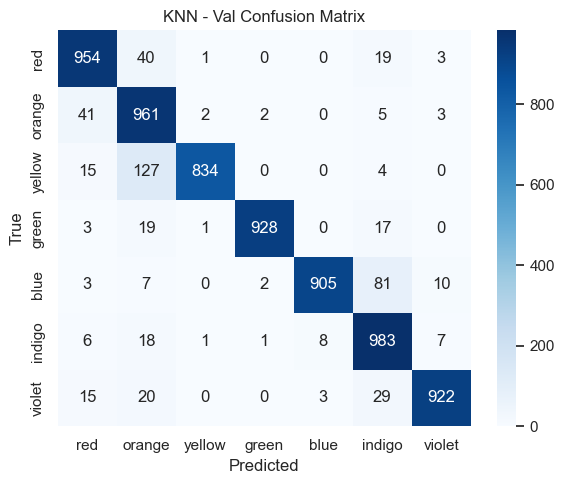


[Test] Metrics:
  Accuracy : 0.9373
  Precision: 0.9430
  Recall   : 0.9373
  F1-score : 0.9380

[Test] Classification report:
              precision    recall  f1-score   support

         red       0.93      0.94      0.93      1017
      orange       0.82      0.96      0.88      1000
      yellow       0.99      0.85      0.92      1054
       green       1.00      0.97      0.98      1010
        blue       0.99      0.92      0.95      1005
      indigo       0.89      0.97      0.93       963
      violet       0.98      0.95      0.96       951

    accuracy                           0.94      7000
   macro avg       0.94      0.94      0.94      7000
weighted avg       0.94      0.94      0.94      7000



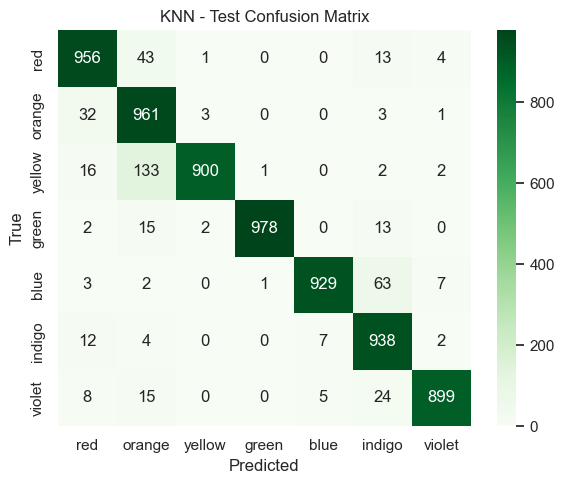

In [ ]:
# ------------------------------------------------------------
# [Cell 3] KNN with hyperparameter tuning (GridSearchCV)
#   - Uses scaled features X_train / X_val / X_test
#   - Parameter search over k, weights, and distance metric
# ------------------------------------------------------------

'''import threading
import psutil
import time

stop_heartbeat = False

def heartbeat():
    start_time = time.time()
    while not stop_heartbeat:
        cpu = psutil.cpu_percent(interval=1)
        elapsed = time.time() - start_time
        print(f"[Heartbeat] CPU: {cpu:.1f}% | Elapsed: {elapsed/60:.2f} min")
        time.sleep(1)


hb_thread = threading.Thread(target=heartbeat)
hb_thread.start()'''

# Define base KNN classifier

knn_base = KNeighborsClassifier(
    n_neighbors=5,
    weights='weight',
    p=2,
    metric='minkowski',
    n_jobs=-1
)

# default KNN classifier


'''param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],         # number of neighbors
    "weights": ["uniform", "distance"],  # uniform weights vs distance weights
    "p": [1,2],                         # 1: Manhattan, 2: Euclidean
}'''

'''# GridSearchCV configuration
knn_grid = GridSearchCV(
    estimator=knn_base,     # base KNN model
    param_grid=param_grid_knn,  # parameter search space
    scoring="accuracy",     # optimization metric (can change to 'f1_weighted')
    cv=3,                   # 3-fold cross-validation on training set
    n_jobs=-1,              # use all available CPU cores
    verbose=2,              # print progress
)
'''
print("[KNN] Starting hyperparameter search...")
'''knn_grid.fit(X_train, y_train)  # fit GridSearchCV on training data'''

stop_heartbeat = True


'''print("\n[KNN] Best parameters:", knn_grid.best_params_)
print("[KNN] Best CV accuracy:", f"{knn_grid.best_score_:.4f}")'''

# Extract best model from grid search
'''knn_best = knn_grid.best_estimator_  # best KNN model according to CV'''

# Evaluate best KNN model using common evaluation function
results_knn = evaluate_classifier(
    model=knn_base,
    model_name="KNN",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    class_names=class_names,
)